# Thunderstruck
## Main Diagnostics

In [25]:
from dataclasses import dataclass, field
from functools import partial

import cartopy.crs as ccrs
import cmocean
import iris
import matplotlib.colors as mcol
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import precip_sum, spatial, spatial_mean, time_mean, toa_net_energy
from aeolus.const import init_const
from aeolus.coord import (
    area_weights_cube,
    broadcast_to_shape,
    coord_to_cube,
    get_cube_rel_days,
    isel,
    regrid_3d,
    replace_z_coord,
    roll_cube_pm180,
)
from aeolus.core import AtmoSim
from aeolus.meta import update_metadata
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    all_sim_file_label,
    capitalise,
    cube_minmeanmax_str,
    figsave,
    hcross,
    subplot_label_generator,
    tex2cf_units,
    timeseries_1d,
    unit_format,
)
from aeolus.region import Region
from aeolus.subset import extract_last_n_days
from iris.coord_systems import GeogCS
from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText
from tqdm.notebook import tqdm

In [2]:
from common import (
    DAYSIDE,
    GROUPS,
    HIGHRES,
    KW_LINE_MARKERS,
    KW_ZERO_LINE,
    LOWRES,
    M09,
    PR92,
    SIMULATIONS,
)
from plot_aux import annotate_heatmap, heatmap

In [3]:
def callback_coord_system(cube, field, filename, const, model=um):
    coord_system = GeogCS(semi_major_axis=const.radius.data)
    for coord_name in [model.x, model.y]:
        cube.coord(coord_name).coord_system = coord_system

In [4]:
@update_metadata(name="flash_rate", units="km-2 yr-1")
def calc_flash_rate(cubelist):
    """Convert number of lightning flashes to flash rate (per km2 per year)."""
    num_fl = cubelist.extract_cube(
        iris.Constraint(
            name="Number_of_lightning_flashes",
            cube_func=lambda cube: cube.shape[-2:] != (1, 1),
        )
    )

    fl_pa_pyr = num_fl / area_weights_cube(num_fl) / ACCUM_PERIOD
    fl_pa_pyr.coord(um.x).bounds = None
    fl_pa_pyr.coord(um.y).bounds = None
    return fl_pa_pyr


@update_metadata(name="total_flash_rate", units="s-1")
def calc_total_flash_rate(cubelist):
    """Convert number of lightning flashes to flash rate (per km2 per year)."""
    num_fl = cubelist.extract_cube(
        iris.Constraint(
            name="Number_of_lightning_flashes",
            cube_func=lambda cube: cube.shape[-2:] != (1, 1),
        )
    )
    num_fl_tot = num_fl / ACCUM_PERIOD
    # num_fl_tot = spatial(num_fl_tot, "mean")
    num_fl_tot = num_fl_tot.collapsed([um.x, um.y], iris.analysis.SUM)

    return num_fl_tot


@update_metadata(name="convective_cloud_depth", units="m")
def calc_cloud_depth(cubelist):
    """Calculate convective cloud depth from 2-224 and 2-225."""
    cld_base_h = cubelist.extract_cube("m01s05i224")
    cld_base_h.units = "kft"
    cld_top_h = cubelist.extract_cube("m01s05i225")
    cld_top_h.units = "kft"
    cld_dep = cld_top_h - cld_base_h
    return cld_dep

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
# show_sim = [*SIMULATIONS.keys()]
show_groups = ["comp", "pres", "surf"]
show_sim = [
    sim_label
    for sim_label in SIMULATIONS.keys()
    if sim_label
    in sum([GROUPS[group_label].simulations for group_label in show_groups], ())
]

ACCUM_PERIOD = iris.cube.Cube(3600 * 24, units="s")  # 1 day

In [7]:
dset = {}
dset[LOWRES] = {}
dset[HIGHRES] = {}
for sim_label in tqdm(show_sim):
    const = init_const("trap1e")  # TODO
    # Low resolution
    datadir = (
        paths.data
        / "raw"
        / "steady"
        / SIMULATIONS[sim_label].lowres_diag_suite  # CHECK
        / "base"
        / SIMULATIONS[sim_label].resolution_low
    )
    dset[LOWRES][sim_label] = AtmoSim(
        iris.load(
            datadir / "umglaa.pe00000*",
            callback=partial(callback_coord_system, const=const),
        ),
        planet="trap1e",  # TODO
        model=um,
    )
    # High resolution
    datadir = (
        paths.data
        / "raw"
        / "steady"
        / SIMULATIONS[sim_label].highres_diag_suite  # CHECK
        / "base"
        / SIMULATIONS[sim_label].resolution_high
    )
    dset[HIGHRES][sim_label] = AtmoSim(
        iris.load(
            datadir / "umglaa.p*00000*",
            callback=partial(callback_coord_system, const=const),
        ),
        planet="trap1e",  # TODO
        model=um,
    )

for i, cube in enumerate(dset[LOWRES][sim_label]._cubes):
    print(f"--|-|-{'-'*17}-|-{'-'*10}-|-{'-'*65}-|-{'-'*10}")
    print(
        f"{i:<2d}|{cube.ndim}| {str(cube.shape):>17}"
        f" | {str(cube.attributes['STASH']):>10}"
        f" | {cube.name():>65} | {str(cube.units):>10}"
    )

  0%|          | 0/14 [00:00<?, ?it/s]

--|-|-------------------|------------|-------------------------------------------------------------------|-----------
0 |3|    (720, 144, 97) | m01s05i210 |                                                        m01s05i210 |    unknown
--|-|-------------------|------------|-------------------------------------------------------------------|-----------
1 |3|    (720, 144, 97) | m01s05i211 |                                                        m01s05i211 |    unknown
--|-|-------------------|------------|-------------------------------------------------------------------|-----------
2 |3|    (720, 144, 97) | m01s05i224 |                                                        m01s05i224 |    unknown
--|-|-------------------|------------|-------------------------------------------------------------------|-----------
3 |3|    (720, 144, 97) | m01s05i225 |                                                        m01s05i225 |    unknown
--|-|-------------------|------------|------------------

## Maps

In [17]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    fmt: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"


DIAGS = {
    "lfr": Diag(
        recipe=lambda AS: roll_cube_pm180(time_mean(calc_flash_rate(AS._cubes))),
        title="Flash Rate",
        units="$km^{-2}$ $yr^{-1}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            norm=mcol.LogNorm(vmin=1e-1, vmax=1e2),
            rasterized=True,
        ),
        fmt="pretty",
    ),
    "cld_dep": Diag(
        recipe=lambda AS: roll_cube_pm180(time_mean(calc_cloud_depth(AS._cubes))),
        title="Convective Cloud Depth",
        units="$km$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.balance_i,
            vmin=0,
            vmax=10,
            rasterized=True,
        ),
        fmt="pretty",
    ),
    "tiwp": Diag(
        recipe=lambda AS: roll_cube_pm180(
            time_mean(AS._cubes.extract_cube("total_ice_water_path"))
        ),
        title="Ice Water Path",
        units="$kg$ $m^{-2}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.ice_r,
            norm=mcol.LogNorm(vmin=1e-2, vmax=1e0),
            # levels=np.arange(0.1, 1.1, 0.1),
            rasterized=True,
        ),
        fmt="pretty",
    ),
     "gwp": Diag(
        recipe=lambda AS: roll_cube_pm180(
            time_mean(AS._cubes.extract_cube("graupel_water_path"))
        ),
        title="Graupel Water Path",
        units="$kg$ $m^{-2}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.dense,
            norm=mcol.LogNorm(vmin=1e-9, vmax=1e-2),
            # levels=np.arange(0.1, 1.1, 0.1),
            rasterized=True,
        ),
        fmt="pretty",
    ),
}

Saved to ../figures/drafts/thunderstruck__n1280__all__gwp__maps.pdf
Size: 45.2 KB


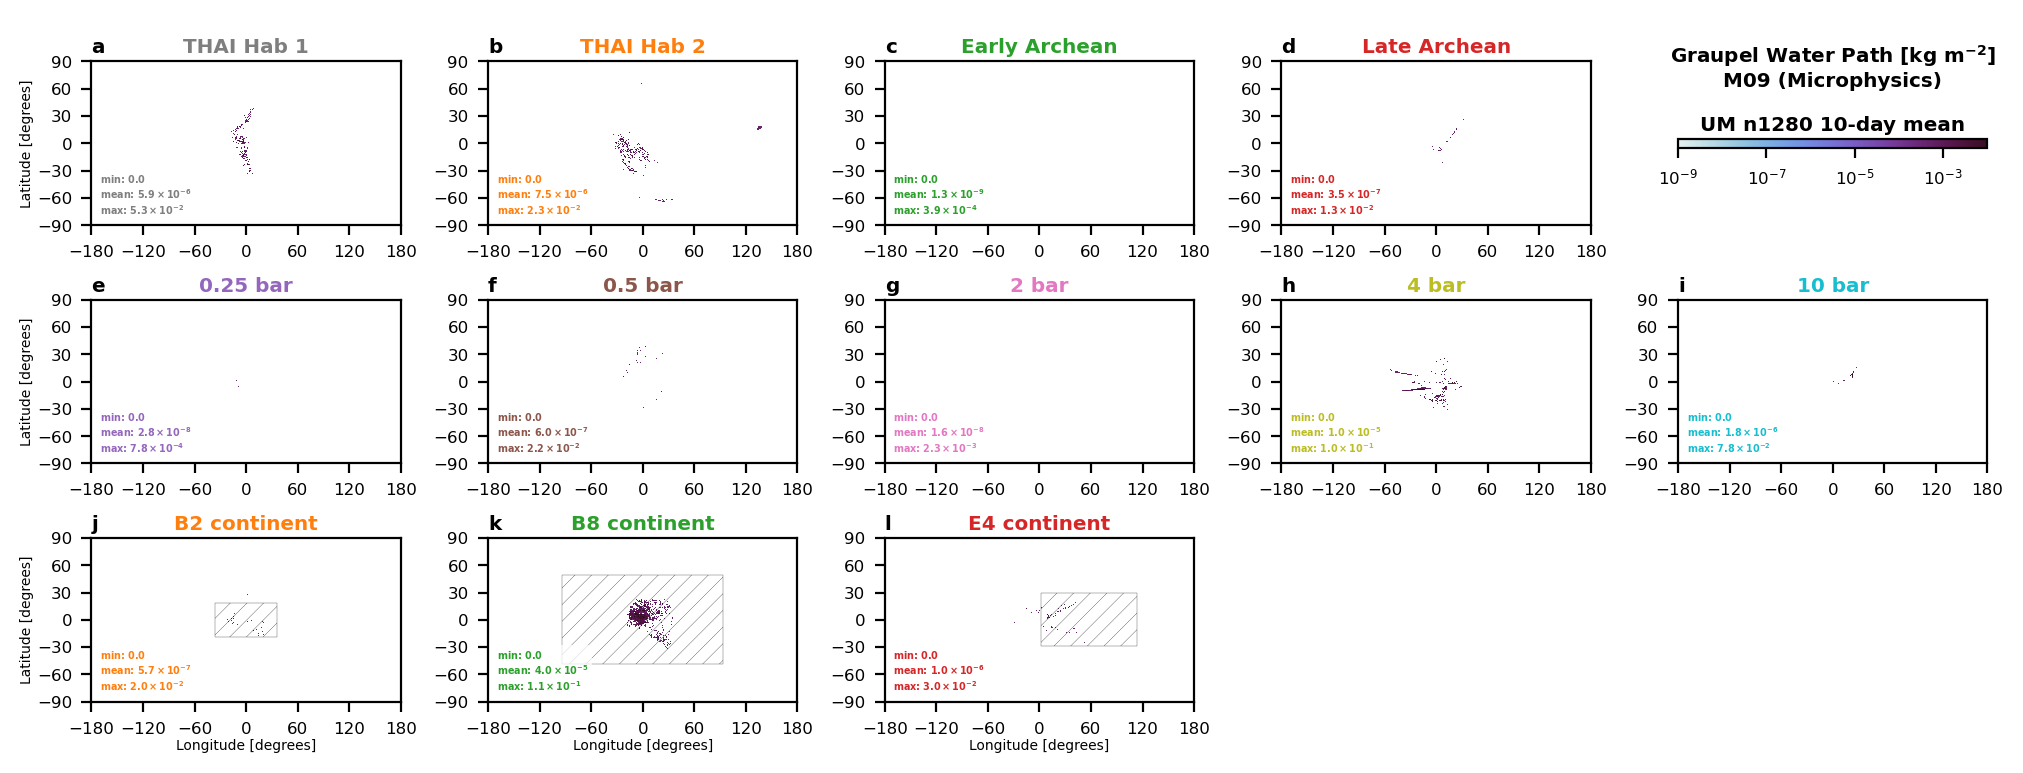

In [18]:
diag_key = "gwp"
# pl_type = "cart"
pl_type = ""
savefig = True
RES = HIGHRES
# RES = HIGHRES

if RES == LOWRES:
    SCHEME = PR92
    T_AVG = "30-day mean"
else:
    SCHEME = M09
    T_AVG = "10-day mean"

ttl = (
    f"\n{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]"
    f"\n{SCHEME}"
    f"\n\nUM {RES} {T_AVG}"
)

if pl_type == "cart":
    subplot_kw = {"projection": ccrs.Orthographic()}
    kw_cart = {"transform": ccrs.PlateCarree()}
else:
    subplot_kw = {}
    kw_cart = {}
    coord_mappings = {
        "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
        "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    }

fig = plt.figure(figsize=(10, 1.25 * len(GROUPS)), layout="constrained")
# fig.suptitle(ttl)

mosaic = [
    [*GROUPS["comp"].simulations] + ["cax"],
    [i for i in GROUPS["pres"].simulations if i != "hab1_1bar"],
    [i for i in GROUPS["surf"].simulations if i != "hab1_aqua"] + ["."] * 2,
]
axd = fig.subplot_mosaic(mosaic, subplot_kw=subplot_kw)  # , gridspec_kw={"hspace": 0.4}

iletters = subplot_label_generator()
for group in GROUPS.keys():
    for sim_label in GROUPS[group].simulations:
        if sim_label in ["hab1_1bar", "hab1_aqua"]:
            continue  # skip duplicate
        ax = axd[sim_label]
        ax.set_title(f"{next(iletters)}", loc="left")
        ax.set_title(
            SIMULATIONS[sim_label].title,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )

        cube = DIAGS[diag_key].recipe(dset[RES][sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        if pl_type == "cart":
            ax.gridlines(draw_labels=True)
        else:
            if coord_mapping := coord_mappings.get(x.name()):
                x.convert_units(coord_mapping["units"])
                ax.set_xticks(coord_mapping["ticks"])
                ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
            if coord_mapping := coord_mappings.get(y.name()):
                y.convert_units(coord_mapping["units"])
                ax.set_yticks(coord_mapping["ticks"])
                ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel(
                    f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
                )
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel(
                    f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
                )

        h = getattr(ax, DIAGS[diag_key].method)(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt, **kw_cart
        )
        if cont := SIMULATIONS[sim_label].continent:
            cont.add_to_ax(
                ax, fc="none", ec="k", linewidth=0.1, hatch="////", **kw_cart
            )
        if (
            iris.util.guess_coord_axis(x) == "X"
            and iris.util.guess_coord_axis(y) == "Y"
        ):
            at = AnchoredText(
                cube_minmeanmax_str(
                    cube,
                    fmt=DIAGS[diag_key].fmt,
                    precision=1,
                    sep="\n",
                    eq_sign=": ",
                ),
                loc="lower left",
                frameon=True,
                prop={
                    "size": "xx-small",
                    "weight": "bold",
                    "color": SIMULATIONS[sim_label].kw_plt["color"],
                },
            )
            at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.75))
            at.patch.set_edgecolor("none")
            ax.add_artist(at)
legend_ax = axd["cax"]
legend_ax.set_aspect(0.2)
cbar = fig.colorbar(h, cax=legend_ax, orientation="horizontal")
legend_ax.set_title(ttl)

if savefig:
    figsave(
        fig,
        paths.figures
        / "drafts"
        / (
            f"thunderstruck__{RES}__all__{diag_key}"
            f"__maps{'__'+pl_type if pl_type else ''}"
        ),
    )

### Vertical velocity histograms

In [52]:
@update_metadata(name="positive_upward_wind_velocity", units="m s-1")
def get_pos_w(cubelist, region, thresh=0.05, model=um):
    """Select positive values vertical velocity."""
    w = cubelist.extract_cube(um.w).extract(region.constraint)
    w_pos = iris.util.mask_cube(w, w.data < thresh)
    return w_pos

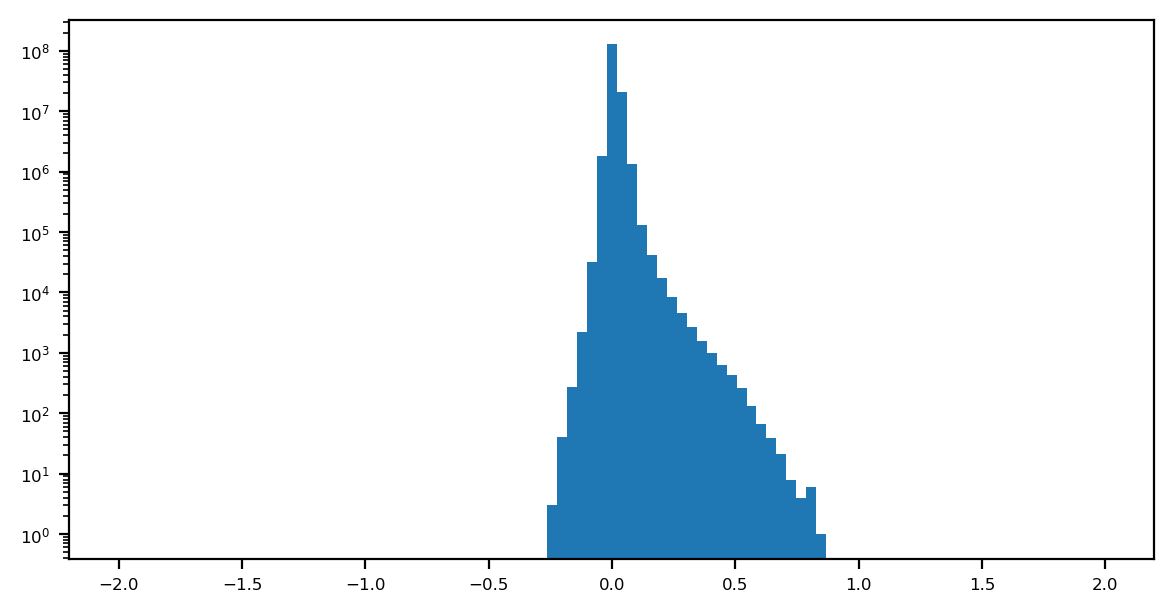

In [69]:
sim_label = "hab2"
w_pos = 

plt.hist(np.asanyarray(w_pos.data.flatten()), bins=np.linspace(-2, 2, 100));
plt.yscale("log")

### Cloud depth histograms

In [78]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    bins: np.ndarray


DIAGS = {
    "cld_dep": Diag(
        recipe=lambda AS: calc_cloud_depth(AS._cubes),
        title="Convective Cloud Depth",
        units="$km$",
        bins=np.arange(0, 21, 1),
    ),
    "w_pos": Diag(
        recipe=lambda AS: get_pos_w(
            AS._cubes, region=Region(-45, 45, -45, 45), thresh=0.05
        ),
        title="Large upward wind",
        units="$m$ $s^{-1}$",
        bins=np.arange(0, 1.51, 0.05),
    ),
}

Saved to ../figures/drafts/thunderstruck__n1280__all__w_pos__hist_step.pdf
Size: 32.5 KB


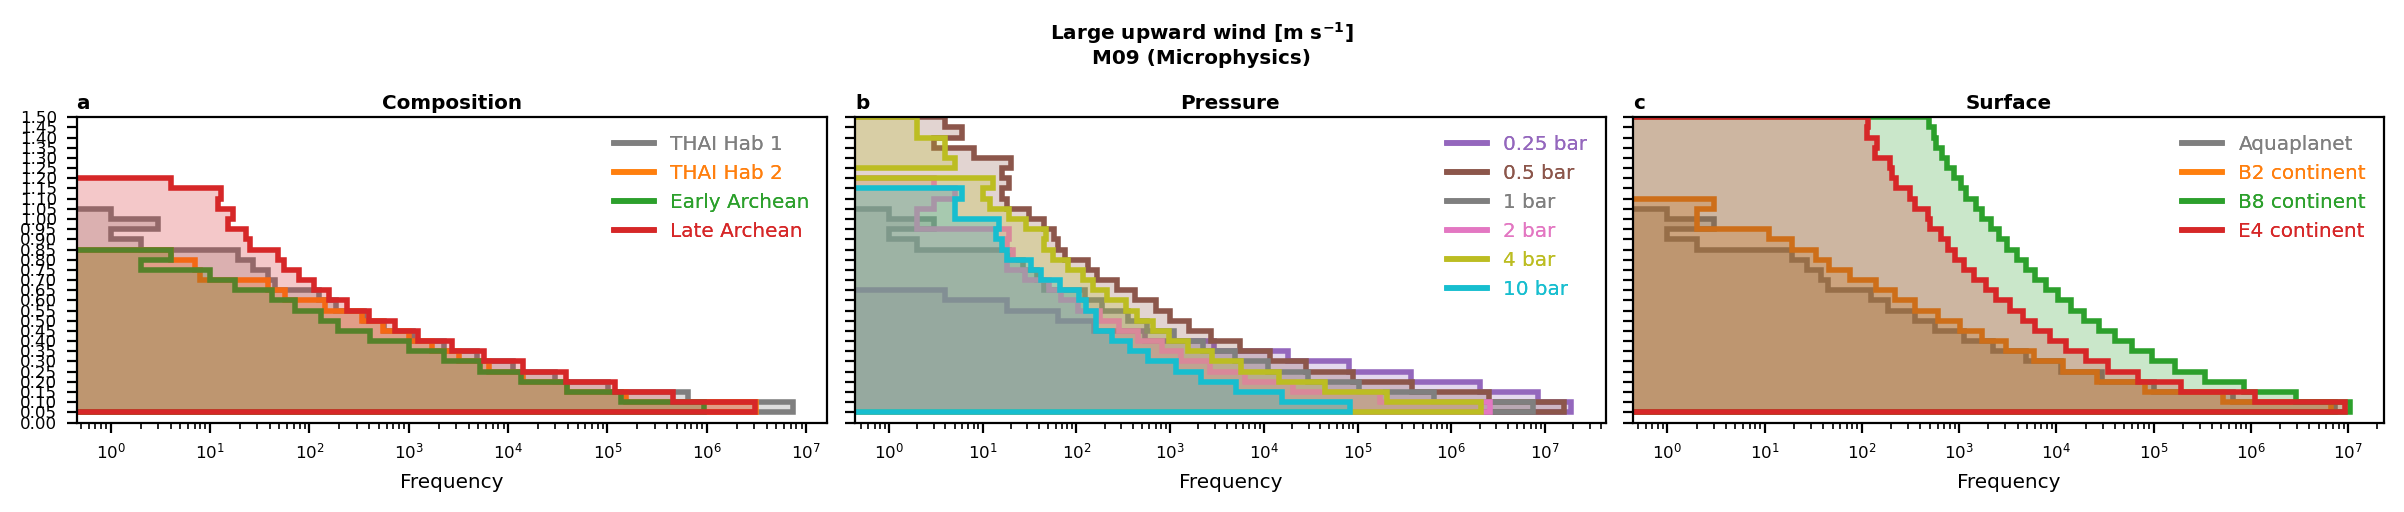

In [81]:
savefig = True
diag_key = "w_pos"
RES = HIGHRES
SCHEME = M09

fig = plt.figure(figsize=(4 * len(GROUPS), 2.5))
fig.suptitle((f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]" f"\n{SCHEME}"))

axd = fig.subplot_mosaic([[*GROUPS.keys()]], sharey=True)

iletters = subplot_label_generator()
for group in GROUPS.keys():
    ax = axd[group]

    stacked_data = []
    for sim_label in GROUPS[group].simulations:
        cube = DIAGS[diag_key].recipe(dset[RES][sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        cube_data = cube.data.ravel().compressed()
    #     stacked_data.append(cube.data.ravel())
    # stacked_data = np.stack(stacked_data, axis=1)

        ax.hist(
            cube_data,
            DIAGS[diag_key].bins,
            histtype="step",
            fill=True,
            alpha=0.25,
            orientation="horizontal",
            edgecolor="none",
            color=SIMULATIONS[sim_label].kw_plt["color"]
        )
        ax.hist(
            cube_data,
            DIAGS[diag_key].bins,
            histtype="step",
            fill=False,
            orientation="horizontal",
            linewidth=2,
            color=SIMULATIONS[sim_label].kw_plt["color"]
        )
    ax.set_title(GROUPS[group].title)
    ax.set_title(f"{next(iletters)}", loc="left")
    ax.set_ylim(DIAGS[diag_key].bins[0], DIAGS[diag_key].bins[-1])
    ax.set_yticks(DIAGS[diag_key].bins)
    ax.set_xscale("log")
    ax.set_xlabel("Frequency", fontsize="large")
    if diag_key == "cld_dep":
        ax.axhline(5, lw=0.5, ls="--", color="k")
    add_custom_legend(
        ax,
        {
            SIMULATIONS[sim_label].title: {
                "color": SIMULATIONS[sim_label].kw_plt["color"],
                "lw": 2,
            }
            for sim_label in GROUPS[group].simulations
        },
        loc="upper right",
        frameon=False,
        fontsize="large",
    )
fig.tight_layout()
fig.align_labels()

if savefig:
    figsave(
        fig,
        paths.figures / "drafts" / f"thunderstruck__{RES}__all__{diag_key}__hist_step",
    )

### Global diagnostics

In [16]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    lim: tuple
    scale: str
    unit_format_kwargs: dict
    rangebar: bool = False

### PR92

In [31]:
DIAGS = {
    "num_flash": Diag(
        recipe=lambda AS: calc_total_flash_rate(AS._cubes),
        title="Total Flash Rate",
        units="$s^{-1}$",
        lim=[5e-3, 5],
        scale="log",
        unit_format_kwargs=dict(),
        rangebar=False,
    ),
    "cld_dep": Diag(
        recipe=lambda AS: calc_cloud_depth(AS._cubes),
        title="Convective Cloud Depth",
        units="$km$",
        lim=[0, 20],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
        rangebar=False,
    ),
}

Saved to ../figures/drafts/thunderstruck__n96__all__num_flash__global.pdf
Size: 50.1 KB


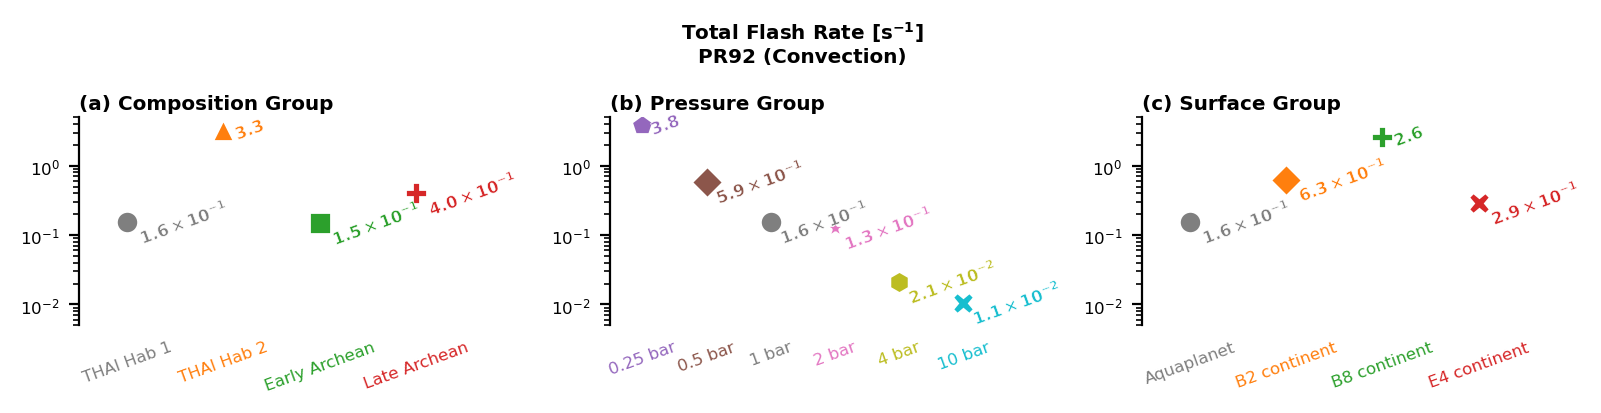

In [39]:
savefig = True
diag_key = "num_flash"
RES = LOWRES
SCHEME = PR92
T_AVG = "30-day mean"

fig = plt.figure(figsize=(8, 2))
fig.suptitle((f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]" f"\n{SCHEME}"))

axd = fig.subplot_mosaic([[*GROUPS.keys()]])

iletters = subplot_label_generator()
for group_label in GROUPS.keys():
    ax = axd[group_label]
    for isim, sim_label in enumerate(GROUPS[group_label].simulations):
        cube = DIAGS[diag_key].recipe(dset_l[sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        value_mean = float(time_mean(spatial(cube, "mean", model=um), model=um).data)

        ax.plot(
            isim,
            value_mean,
            marker=SIMULATIONS[sim_label].kw_plt["marker"],
            markersize=8,
            markeredgecolor="w",
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
        kw_text.update(color=SIMULATIONS[sim_label].kw_plt["color"])
        try:
            ax.text(
                isim + txt_hor_offset,
                value_mean,
                unit_format(value_mean, **DIAGS[diag_key].unit_format_kwargs),
                va="center",
                **kw_text,
            )
        except Exception as e:
            print(e)
    ax.set_xlim(-0.5, len(GROUPS[group_label].simulations) - 0.5)
    ax.set_xticks(range(len(GROUPS[group_label].simulations)))
    ax.set_xticklabels(
        [SIMULATIONS[sim_label].title for sim_label in GROUPS[group_label].simulations],
        size="medium",
        rotation=20,
    )
    for xtick, sim_label in zip(ax.get_xticklabels(), GROUPS[group_label].simulations):
        xtick.set_color(SIMULATIONS[sim_label].kw_plt["color"])
    ax.set_yscale(DIAGS[diag_key].scale)
    ylabel = f"{DIAGS[diag_key].title}"
    # if (tex_units := DIAGS[diag_key].units) != "1":
    #     ylabel += f" [{tex_units}]"
    # ylabel = ylabel.replace("\n", " ")
    ax.set_title(f"({next(iletters)}) {GROUPS[group_label].title} Group", loc="left")

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_ylim(DIAGS[diag_key].lim)
    ax.spines.left.set_bounds(DIAGS[diag_key].lim)
    ax.tick_params(axis="x", which="both", length=0, pad=5)
    ax.grid(visible=False, axis="x")

fig.tight_layout()
fig.align_labels()

if savefig:
    figsave(
        fig,
        paths.figures / "drafts" / f"thunderstruck__{RES}__all__{diag_key}__global",
    )

In [68]:
DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(um.t_sfc),
        title="Surface Temperature",
        units="K",
        lim=[140, 320],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
        rangebar=True,
    ),
    "caf": Diag(
        recipe=lambda cl: cl.extract_cube(um.caf),
        title="Cloud Fraction",
        units="%",
        lim=[0, 100],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
        rangebar=False,
    ),
    "ls_prec": Diag(
        recipe=partial(precip_sum, const=const),
        title="Large-scale Precipitation Rate",
        units="$mm$ $day^{-1}$",
        lim=[0, 2],
        scale="linear",
        unit_format_kwargs=dict(),
        rangebar=False,
    ),
    "num_flash": Diag(
        recipe=calc_total_flash_rate,
        title="Total Flash Rate",
        units="$s^{-1}$",
        lim=[0, 10],
        scale="linear",
        unit_format_kwargs=dict(),
        rangebar=False,
    ),
    "tiwp": Diag(
        recipe=lambda cl: cl.extract_cube("total_ice_water_path"),
        title="Total Ice Water Path",
        units="$g$ $m^{-2}$",
        lim=[10, 100],
        scale="linear",
        unit_format_kwargs=dict(),
        rangebar=False,
    ),
    "gwp": Diag(
        recipe=lambda cl: cl.extract_cube("graupel_water_path"),
        title="Graupel Water Path",
        units="$g$ $m^{-2}$",
        lim=[1e-6, 1e-1],
        scale="log",
        unit_format_kwargs=dict(),
        rangebar=False,
    ),
}

In [62]:
subset_cube = lambda cube: extract_last_n_days(cube, days=5)
# subset_cube = lambda cube: cube
# constrain_spatially = lambda cube: cube.extract(DAYSIDE.constraint)

In [63]:
diag_computed = {}
for sim_label in tqdm(show_sim):
    diag_computed[sim_label] = {}
    for diag_key in tqdm(DIAGS.keys()):
        cube = DIAGS[diag_key].recipe(dset[HIGHRES][sim_label]._cubes)
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        cube = subset_cube(cube)
        diag_computed[sim_label][diag_key] = {
            # "median": float(
            #     time_mean(
            #         spatial(
            #             iris.util.mask_cube(cube, cube.data == 0.0), "median", model=um
            #         ),
            #         model=um,
            #     ).data
            # ),
            "mean": float(time_mean(spatial(cube, "mean", model=um), model=um).data),
            # "std": float(time_mean(spatial(cube, "std_dev", model=um), model=um).data),
            "min": float(time_mean(spatial(cube, "min", model=um), model=um).data),
            "max": float(time_mean(spatial(cube, "max", model=um), model=um).data),
        }

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [69]:
# diag_keys = ["t_sfc", "caf", "ls_prec", "num_flash"]
diag_keys = ["t_sfc", "caf", "ls_prec", "gwp", "tiwp", "num_flash"]
# diag_keys = ["num_flash"]

txt_hor_offset = 0.1
kw_text = dict(
    ha="left",
    weight="bold",
    size="medium",
    rotation=20,
    path_effects=[path_effects.Stroke(linewidth=0.25, foreground="w")],  # #555555
)

Saved to ../figures/drafts/thunderstruck__n1280__t_sfc_caf_ls_prec_gwp_tiwp_num_flash__comp__global.pdf
Size: 82.7 KB
Saved to ../figures/drafts/thunderstruck__n1280__t_sfc_caf_ls_prec_gwp_tiwp_num_flash__pres__global.pdf
Size: 111.3 KB
Saved to ../figures/drafts/thunderstruck__n1280__t_sfc_caf_ls_prec_gwp_tiwp_num_flash__surf__global.pdf
Size: 86.3 KB


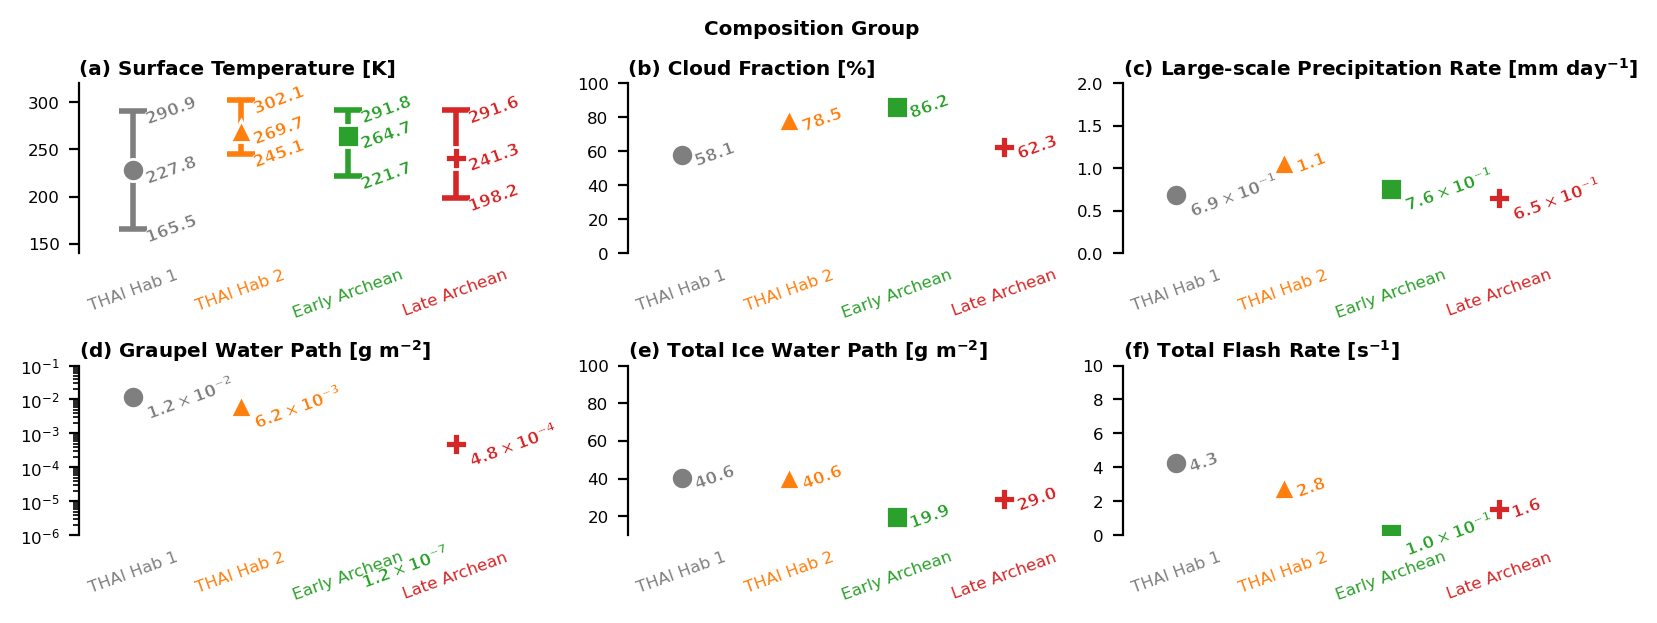

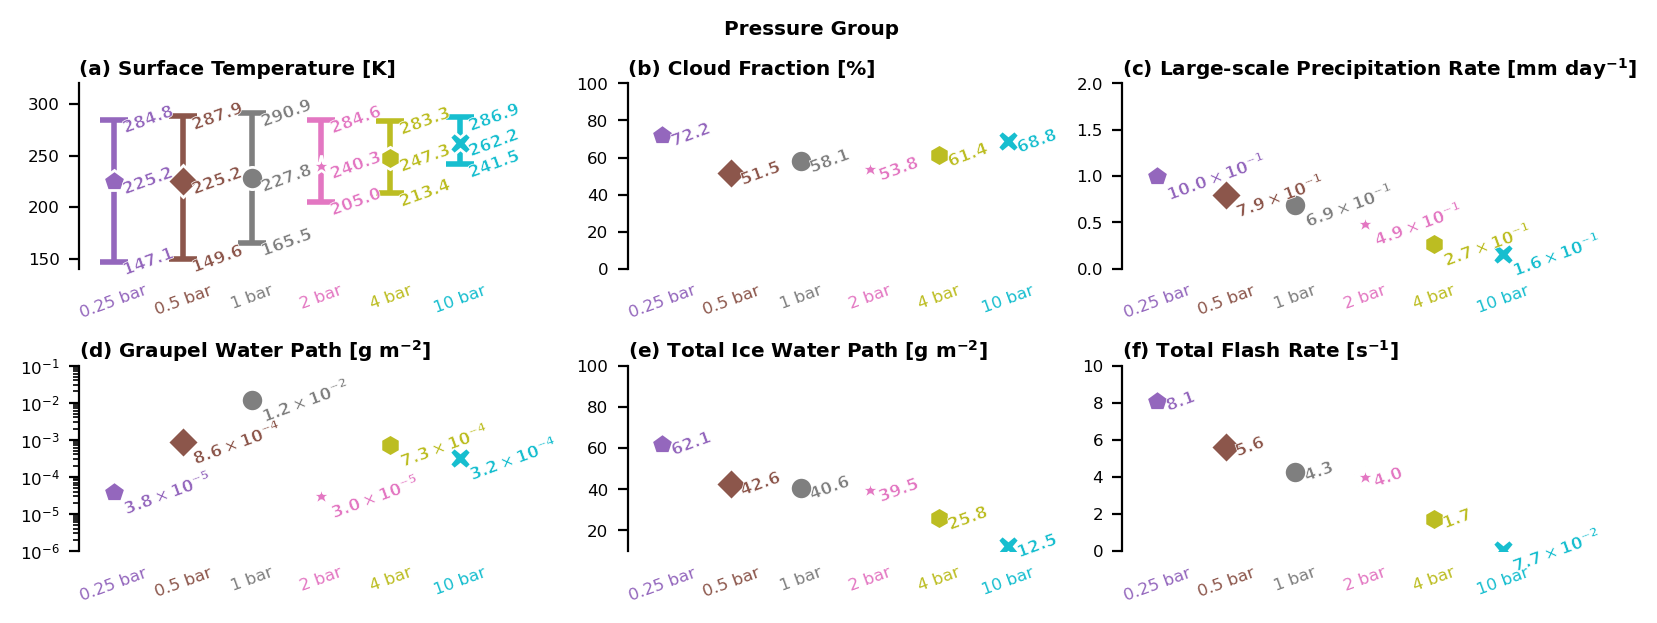

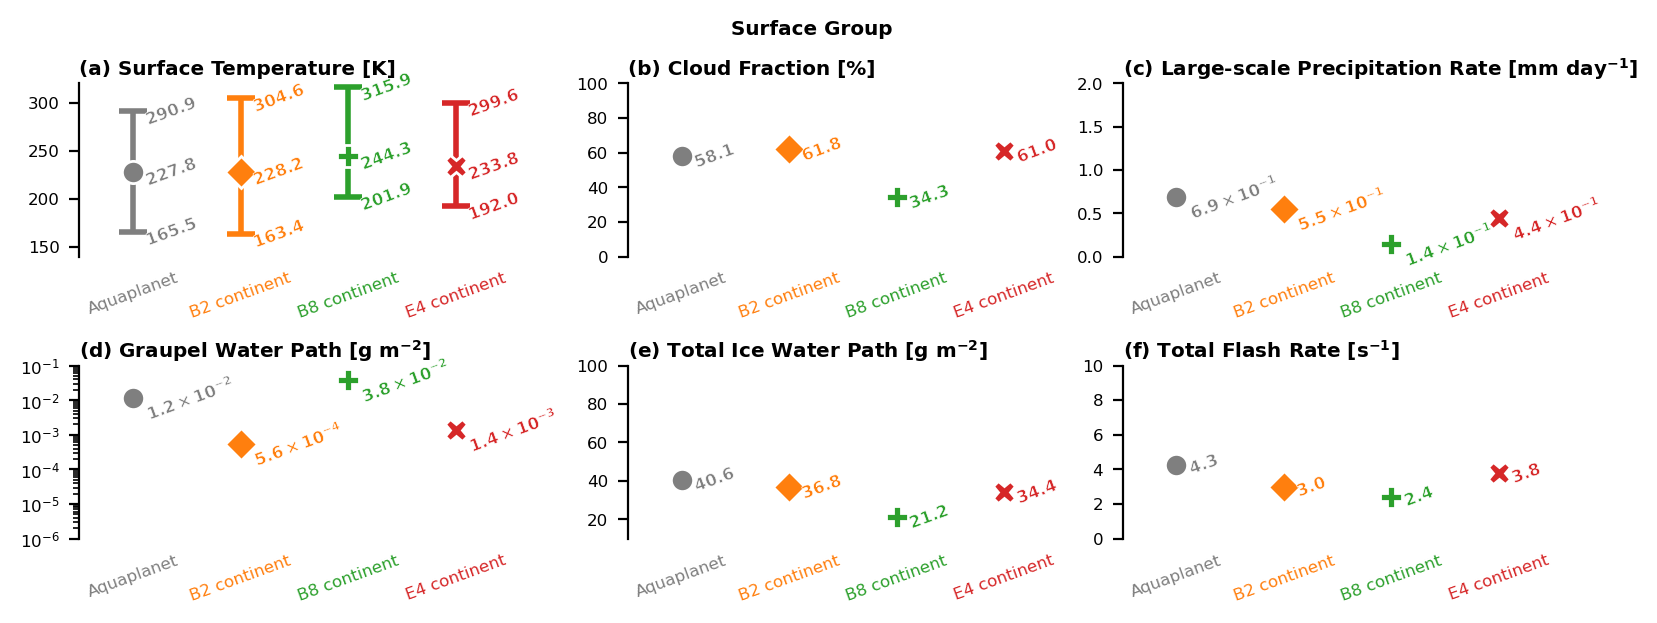

In [70]:
savefig = True
# with plt.style.context("ggplot"):
# fig = plt.figure(
#     figsize=(8, len(show_groups) * len(diag_keys) / 2), layout="constrained"
# )
# subfigs = fig.subfigures(nrows=len(show_groups), ncols=1, squeeze=False)[:, 0]

for group_label in show_groups:
    # subfig
    fig = plt.figure(figsize=(8, len(diag_keys) // 2), layout="constrained")
    fig.suptitle(f"{GROUPS[group_label].title} Group", fontweight="bold")
    # subfig.suptitle(f"{GROUPS[group_label].title} Group", fontweight="bold")
    axd = fig.subplot_mosaic(
        [diag_keys[: len(diag_keys) // 2], diag_keys[len(diag_keys) // 2 :]],
        # gridspec_kw={"wspace": 0.15, "hspace": 0.3},
    )
    iletters = subplot_label_generator()
    for diag_key in diag_keys:
        ax = axd[diag_key]
        for isim, sim_label in enumerate(GROUPS[group_label].simulations):
            value_mean = diag_computed[sim_label][diag_key]["mean"]
            value_min = diag_computed[sim_label][diag_key]["min"]
            value_max = diag_computed[sim_label][diag_key]["max"]
            yerr = [[abs(value_min - value_mean)], [abs(value_max - value_mean)]]
            if DIAGS[diag_key].rangebar:
                ax.errorbar(
                    isim,
                    value_mean,
                    yerr=yerr,
                    fmt=SIMULATIONS[sim_label].kw_plt["marker"],
                    capsize=5,
                    capthick=2,
                    markersize=8,
                    markeredgecolor="w",
                    color=SIMULATIONS[sim_label].kw_plt["color"],
                    elinewidth=2,
                )
            else:
                ax.plot(
                    isim,
                    value_mean,
                    marker=SIMULATIONS[sim_label].kw_plt["marker"],
                    markersize=8,
                    markeredgecolor="w",
                    color=SIMULATIONS[sim_label].kw_plt["color"],
                )
            kw_text.update(color=SIMULATIONS[sim_label].kw_plt["color"])
            try:
                ax.text(
                    isim + txt_hor_offset,
                    value_mean,
                    unit_format(value_mean, **DIAGS[diag_key].unit_format_kwargs),
                    va="center",
                    **kw_text,
                )
                if DIAGS[diag_key].rangebar:
                    ax.text(
                        isim + txt_hor_offset,
                        value_max,
                        unit_format(value_max, **DIAGS[diag_key].unit_format_kwargs),
                        va="center",
                        **kw_text,
                    )
                    ax.text(
                        isim + txt_hor_offset,
                        value_min,
                        unit_format(value_min, **DIAGS[diag_key].unit_format_kwargs),
                        va="center",
                        **kw_text,
                    )
            except Exception as e:
                print(e)
                pass
        ax.set_xlim(-0.5, len(GROUPS[group_label].simulations) - 0.5)
        ax.set_xticks(range(len(GROUPS[group_label].simulations)))
        ax.set_xticklabels(
            [
                SIMULATIONS[sim_label].title
                for sim_label in GROUPS[group_label].simulations
            ],
            size="medium",
            rotation=20,
        )
        for xtick, sim_label in zip(
            ax.get_xticklabels(), GROUPS[group_label].simulations
        ):
            xtick.set_color(SIMULATIONS[sim_label].kw_plt["color"])
        ax.set_yscale(DIAGS[diag_key].scale)
        ylabel = f"{DIAGS[diag_key].title}"
        if (tex_units := DIAGS[diag_key].units) != "1":
            ylabel += f" [{tex_units}]"
        ylabel = ylabel.replace("\n", " ")
        ax.set_title(f"({next(iletters)}) {ylabel}", loc="left")

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.set_ylim(DIAGS[diag_key].lim)
        ax.spines.left.set_bounds(DIAGS[diag_key].lim)
        ax.tick_params(axis="x", which="both", length=0, pad=5)
        ax.grid(visible=False, axis="x")

    if savefig:
        figsave(
            fig,
            paths.figures
            / "drafts"
            / (
                f"thunderstruck__{HIGHRES}__{'_'.join(diag_keys)}"
                f"__{group_label}__global"
            ),
        )

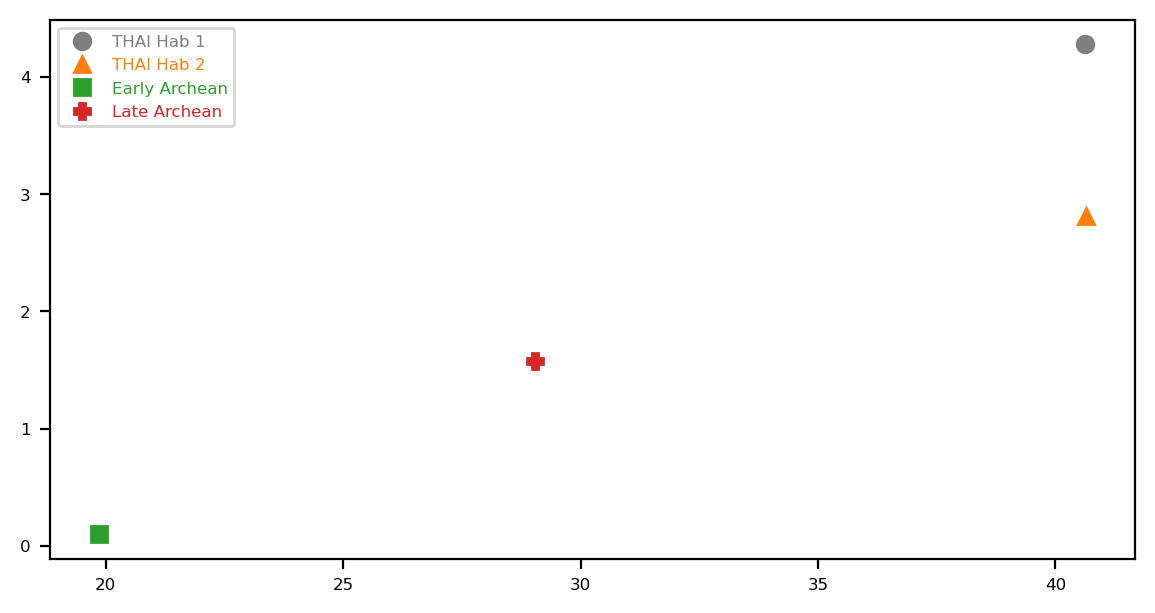

In [18]:
group_label = "comp"
ax = plt.axes()

for sim_label in GROUPS[group_label].simulations:
    ax.plot(
        diag_computed[sim_label]["tiwp"]["mean"],
        diag_computed[sim_label]["num_flash"]["mean"],
        marker=SIMULATIONS[sim_label].kw_plt["marker"],
        color=SIMULATIONS[sim_label].kw_plt["color"],
        linestyle="",
        label=SIMULATIONS[sim_label].title,
    )
ax.legend();

In [80]:
diag_keys = ["t_sfc", "caf", "ls_prec", "num_flash", "tiwp", "gwp"]

group_label = "pres"

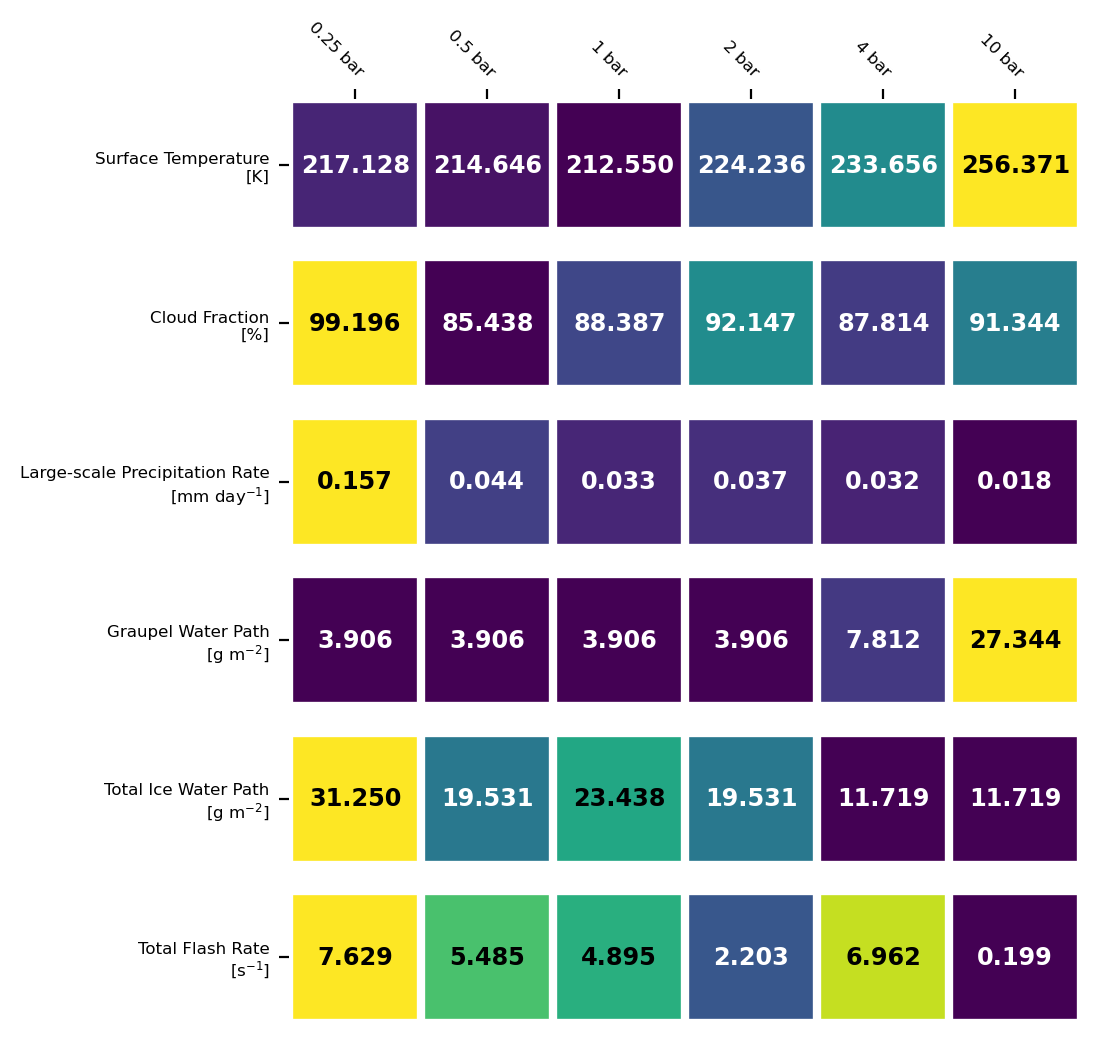

In [134]:
fig, axs = plt.subplots(
    figsize=(8, 1 * len(diag_keys)), nrows=len(diag_keys), squeeze=True
)

for idiag, (ax, diag_key) in enumerate(zip(axs, diag_keys)):
    arr2d = np.array(
        [
            [
                diag_computed[sim_label][diag_key]["median"]
                for sim_label in GROUPS[group_label].simulations
            ]
        ]
    )
    im = heatmap(
        arr2d,
        [f"{DIAGS[diag_key].title}\n[{DIAGS[diag_key].units}]"],
        [SIMULATIONS[sim_label].title for sim_label in GROUPS[group_label].simulations],
        ax=ax,
        add_cbar=False,
        cmap="viridis",
    )
    if idiag > 0:
        ax.set_xticks([])
    annotate_heatmap(
        im,
        textcolors=["white", "black"],
        weight="bold",
        size="x-large",
        valfmt="{x:.3f}",
    );

In [11]:
SS_REGION = Region(-1, 1, 19, 21)

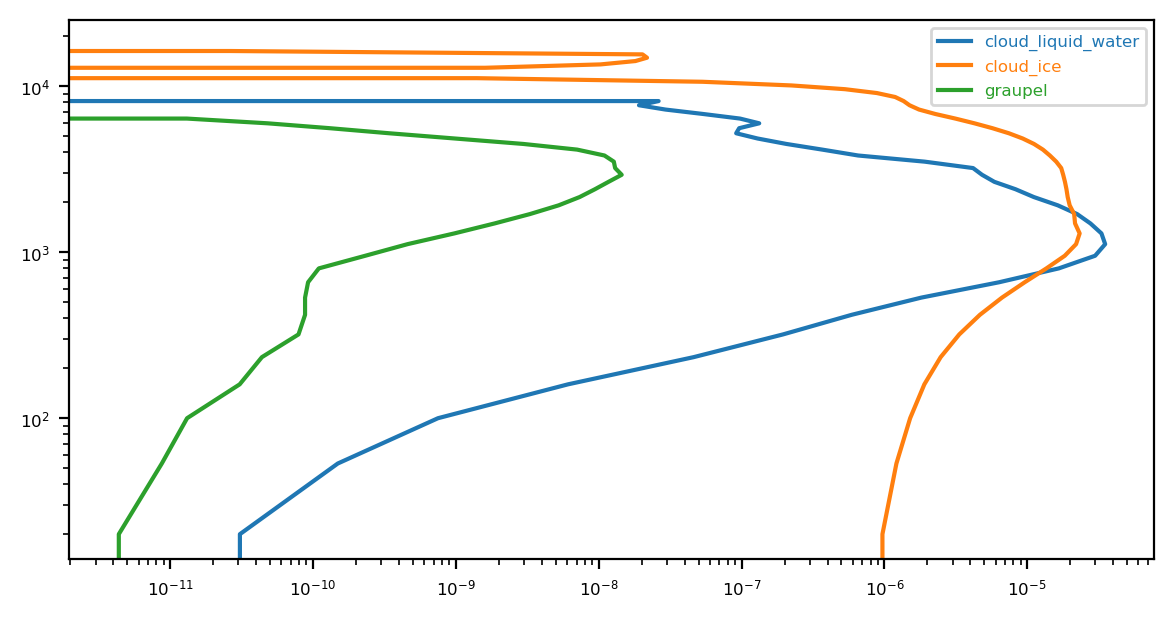

In [9]:
ax = plt.axes()

for diag in [
    "cloud_liquid_water_mixing_ratio",
    "cloud_ice_mixing_ratio",
    "graupel_mixing_ratio",
]:
    cube = spatial_mean(dset["c"].extract_cube(diag).extract(SS_REGION.constraint))
    ax.plot(
        cube.data,
        cube.coord(um.z).points,
        label=diag.removesuffix("_mixing_ratio"),
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

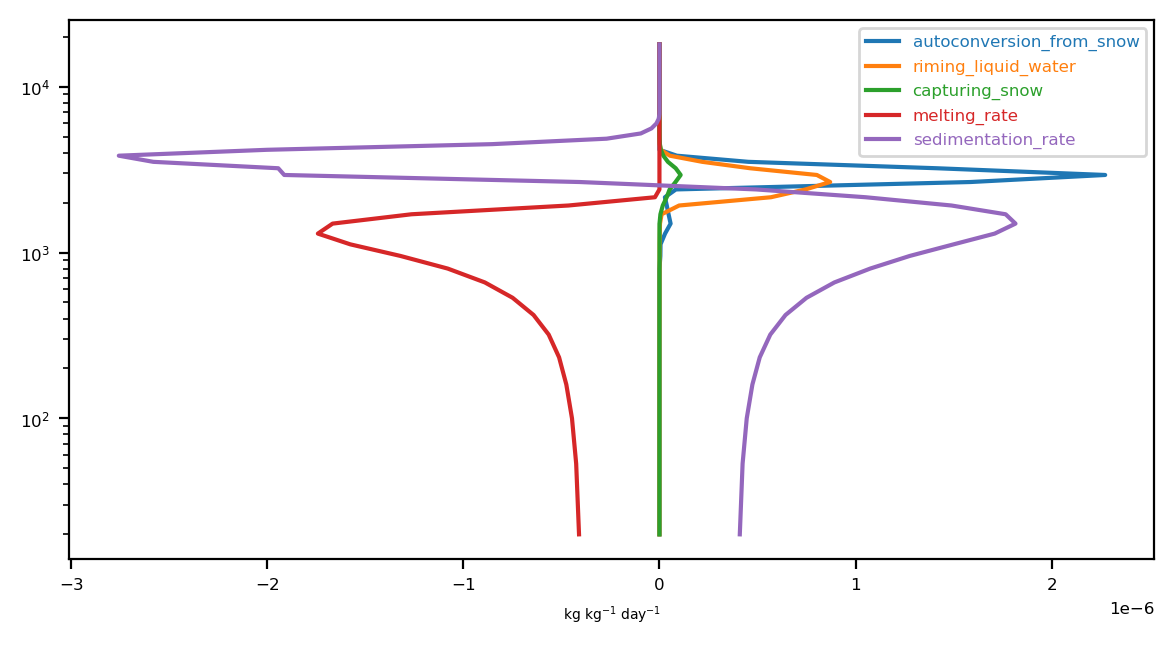

In [23]:
ax = plt.axes()

for diag in [
    "rate_of_increase_of_graupel_mass_due_to_autoconversion_from_snow",
    "rate_of_change_of_graupel_mass_due_to_riming_liquid_water",
    "rate_of_change_of_graupel_mass_due_to_capturing_snow",
    "melting_rate_of_graupel_mass",
    "sedimentation_rate_of_graupel_mass",
]:
    cube = spatial_mean(dset["c"].extract_cube(diag).extract(SS_REGION.constraint))
    if diag == "melting_rate_of_graupel_mass":
        factor = -1
    else:
        factor = 1
    factor = 86400 * factor
    ax.plot(
        factor * cube.data,
        cube.coord(um.z).points,
        label=diag.removeprefix("rate_of_change_of_graupel_mass_due_to_")
        .removeprefix("rate_of_increase_of_graupel_mass_due_to_")
        .removesuffix("_of_graupel_mass"),
    )
# ax.set_xscale("symlog")
ax.set_yscale("log")
ax.set_xlabel("$kg$ $kg^{-1}$ $day^{-1}$")
ax.legend();

In [19]:
area = area_weights_cube(dset["e"].extract_cube("Number_of_lightning_flashes"))
area.collapsed([um.y, um.x], iris.analysis.SUM).data * 2 / 1e14

/home/ds591/miniforge3/envs/thunderstruck/lib/python3.12/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


7.026261273952555

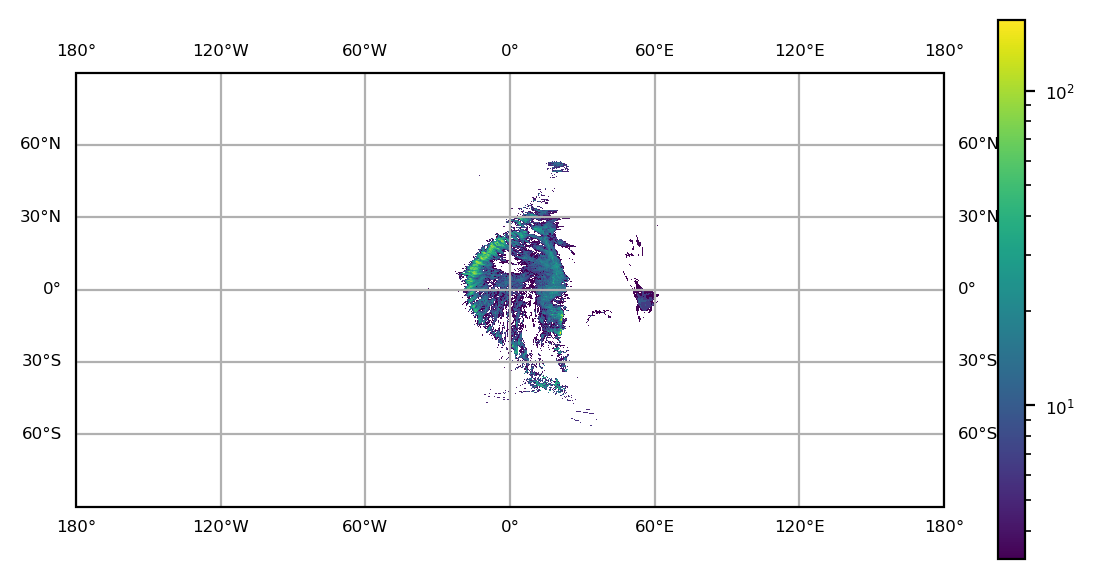

In [22]:
num_flashes = dset["e"].extract_cube("Number_of_lightning_flashes")

flashes_per_area = num_flashes / area_weights_cube(num_flashes) / acc_period
flashes_per_area.convert_units("km-2 yr-1")
flashes_per_area.coord(um.x).bounds = None
flashes_per_area.coord(um.y).bounds = None

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
p = ax.pcolormesh(
    flashes_per_area.coord(um.x).points,
    flashes_per_area.coord(um.y).points,
    flashes_per_area.data,
    norm=mcol.LogNorm(),
    transform=ccrs.PlateCarree(),
)
ax.gridlines(draw_labels=True)
fig.colorbar(p, ax=ax)
# hcross(roll_cube_pm180(flashes_per_area), norm=mcol.LogNorm())

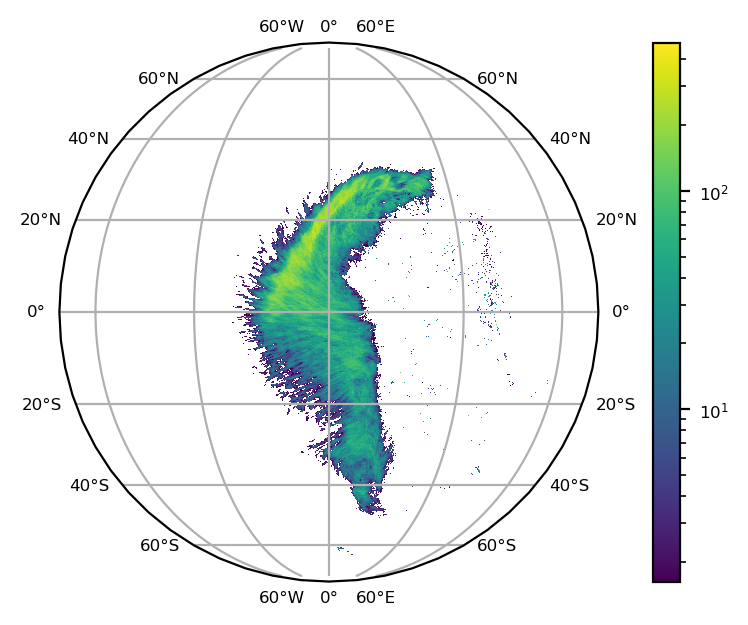

In [16]:
num_flashes = dset["e"].extract_cube("Number_of_lightning_flashes")

flashes_per_area = num_flashes / area_weights_cube(num_flashes) / acc_period
flashes_per_area.convert_units("km-2 yr-1")
flashes_per_area.coord(um.x).bounds = None
flashes_per_area.coord(um.y).bounds = None

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic()))
p = ax.pcolormesh(
    flashes_per_area.coord(um.x).points,
    flashes_per_area.coord(um.y).points,
    flashes_per_area.data,
    norm=mcol.LogNorm(),
    transform=ccrs.PlateCarree(),
)
ax.gridlines(draw_labels=True)
fig.colorbar(p, ax=ax)
# hcross(roll_cube_pm180(flashes_per_area), norm=mcol.LogNorm())

## Flash rate on Earth

In [11]:
# 1.41e9 flashes / year (Finney+ 2018)
1.41e9 / (86400 * 365)  # per second

44.71080669710807

In [23]:
num_flashes.collapsed([um.y, um.x], iris.analysis.SUM).data / 86400

4.898564814814815

In [24]:
spatial(num_flashes, "sum").data / 86400

2.962702149447879e-06

In [25]:
spatial_mean(num_flashes).data / 86400

2.962702149447878e-06

In [10]:
print((time_mean(cl.extract_cube("graupel_water_path")).data > 0).sum())

140


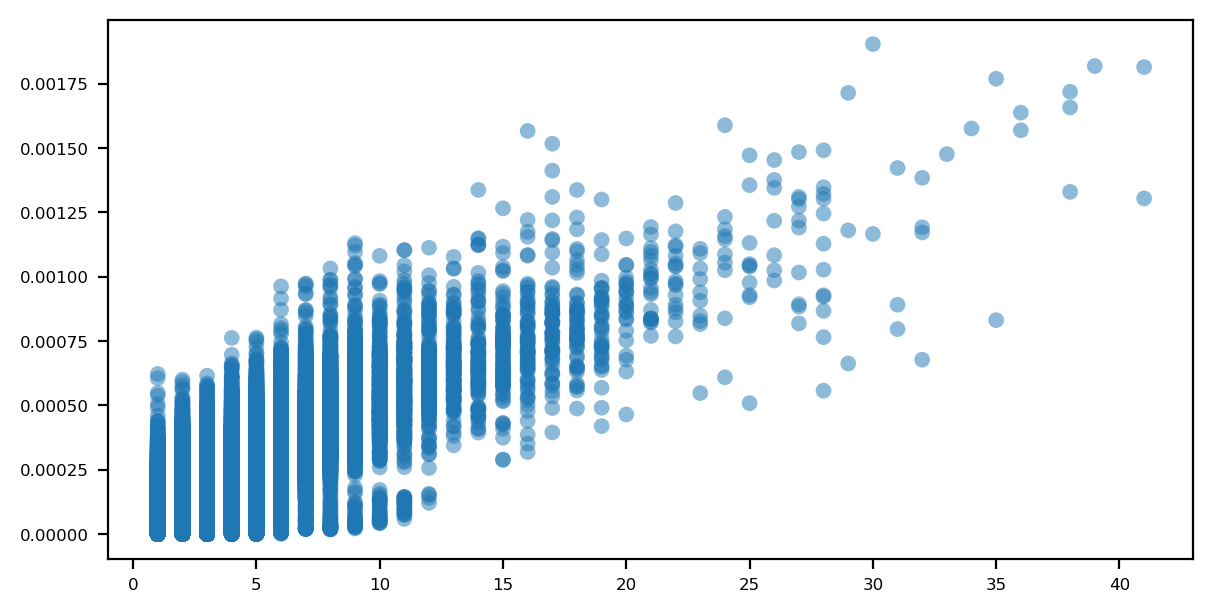

In [38]:
a = cl[5].data.flatten()
plt.scatter(
    a[a > 0], cl[14].data.flatten()[a > 0], alpha=0.5, edgecolors="none", s=2**5
)

<Axes: >

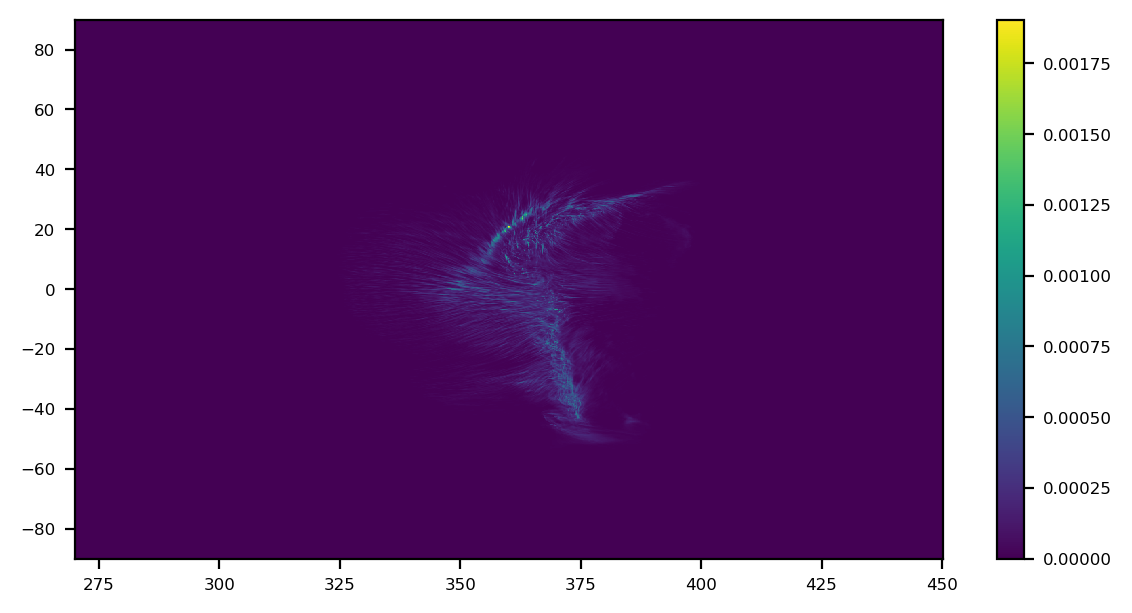

In [39]:
hcross(cl[14])

In [18]:
lfr = cl.extract("lightning_flash_rate_due_to_total_ice_water_path").extract_cube(
    iris.Constraint(
        cube_func=lambda cube: cube.coord(um.x).shape[0] < 2000
    )  # dayside-only
)
lfr_per_area = lfr / area_weights_cube(lfr) * 0.05  # / acc_period.data
lfr_per_area.convert_units("km-2 yr-1")
# lfr_m = iris.util.mask_cube(lfr, np.isclose(lfr.data, 0.0))

Text(0.5, 1.0, 'Lightning Flash Rate Due To Total Ice Water Path / flashes km-2 yr-1')

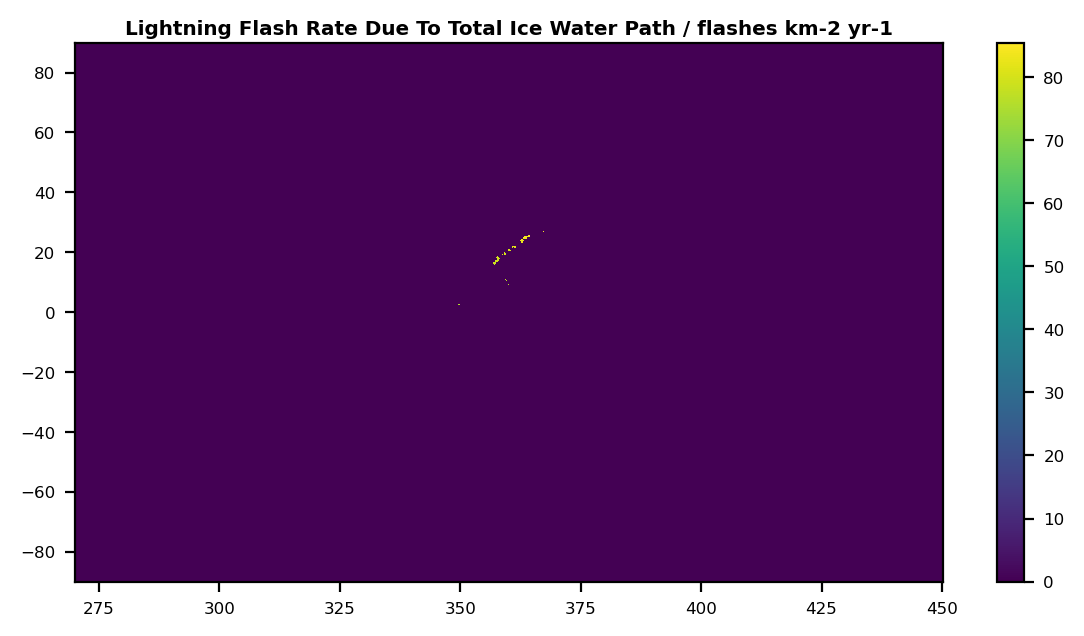

In [19]:
ax = hcross(lfr_per_area)
ax.set_title(f"{capitalise(lfr.name())} / flashes {lfr_per_area.units}")

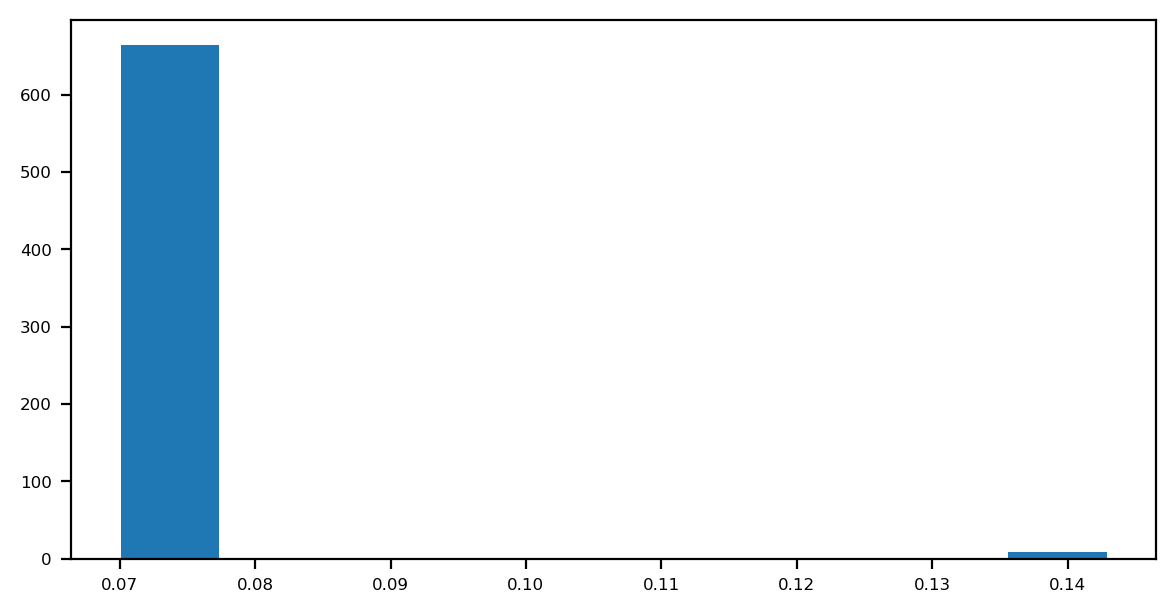

In [9]:
plt.hist(iris.util.mask_cube(lfr_per_area, np.isclose(lfr.data, 0.0)).data.flatten());

In [10]:
temp = replace_z_coord(isel(cl.extract_cube(um.temp), um.t, t_idx))
q_graup = regrid_3d(
    replace_z_coord(isel(cl.extract_cube("graupel_mixing_ratio"), um.t, t_idx)),
    temp,
    model=um,
)
w = regrid_3d(replace_z_coord(isel(cl.extract_cube(um.w), um.t, t_idx)), temp, model=um)

wq_graup = w * q_graup

In [11]:
def _interp_vert(cube, tgt_cube, tgt_levels=[273.15 - 15]):
    cube_rev = iris.util.reverse(cube, um.z)
    tgt_rev = iris.util.reverse(tgt_cube, um.z)
    cube_rev_interp = stratify.relevel(
        cube_rev,
        tgt_rev,
        tgt_levels=tgt_levels,
        axis=um.z,
        # interpolator=partial(
        #     stratify.stratify.interpolate,
        #     interpolation=stratify.stratify.INTERPOLATE_LINEAR,
        #     extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
        # ),
    )
    return iris.util.squeeze(cube_rev_interp)


wq_graup_at_15degc = _interp_vert(wq_graup, temp)
height_at_15degc = _interp_vert(coord_to_cube(temp, um.z), temp)
w_at_15degc = _interp_vert(w, temp)
q_graup_at_15degc = _interp_vert(q_graup, temp)

In [12]:
idx_max_y, idx_max_x = np.unravel_index(
    np.argmax(wq_graup_at_15degc.data), wq_graup_at_15degc.shape
)
idx_max_y, idx_max_x

(0, 0)

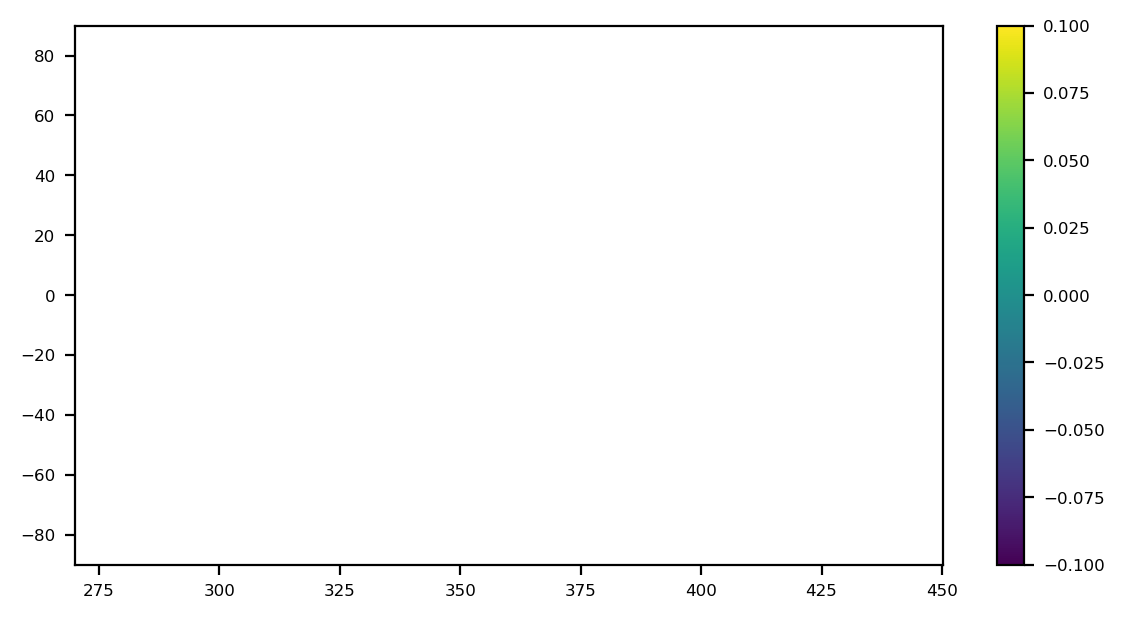

In [13]:
ax = hcross(wq_graup_at_15degc)
# ax.plot(
#     wq_graup_at_15degc.coord(um.x).points[idx_max_x],
#     wq_graup_at_15degc.coord(um.y).points[idx_max_y],
#     marker="o",
#     ms=10,
# )

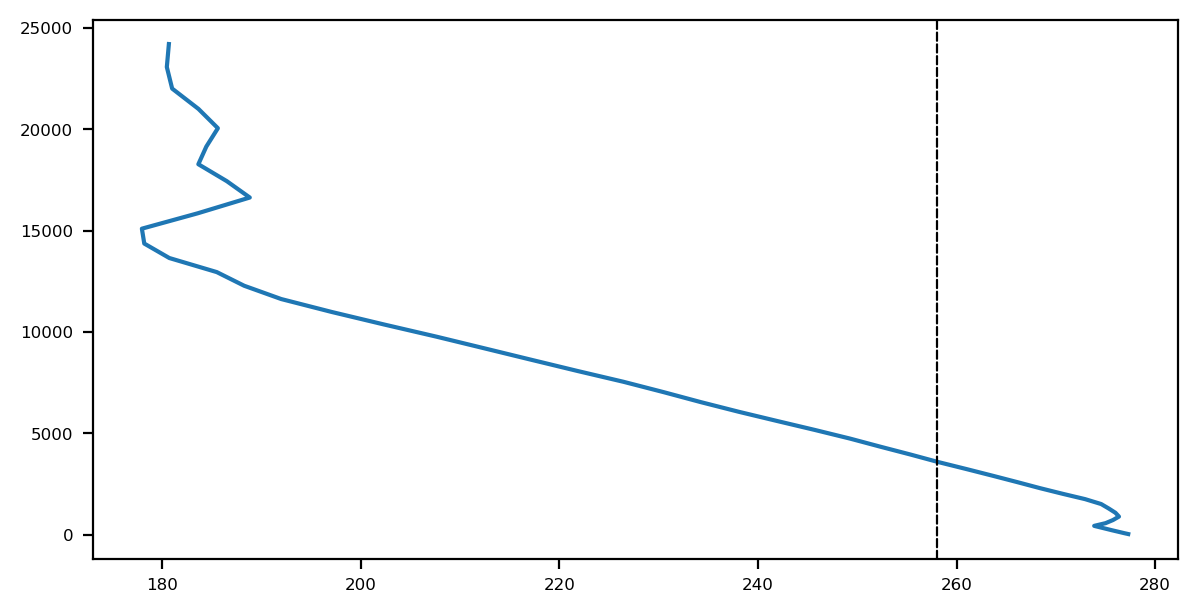

In [16]:
plt.plot(temp[:, 1000, 1000].data, temp.coord(um.z).points)
plt.axvline(258, **KW_ZERO_LINE)

<Axes: >

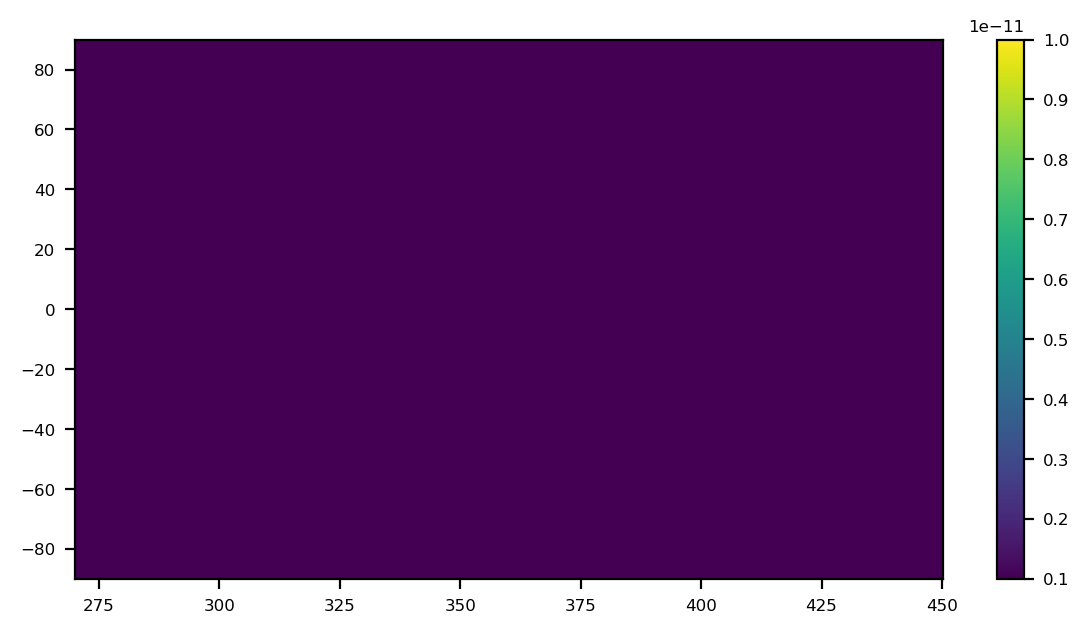

In [32]:
hcross(time_mean(cl.extract_cube("graupel_water_path")), vmin=1e-12, vmax=1e-11)

2

In [5]:
dset = {}
for sim_label in tqdm(show_sim):
    dset[sim_label] = AtmoSim(
        iris.load(
            paths.data
            / "raw"
            / "spinup"
            / SIMULATIONS[sim_label].highres_spinup_suite
            / "base"
            / SIMULATIONS[sim_label].resolution
            / "umglaa.pa*"
        ),
        planet="trap1e",  # TODO
        model=um,
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
lons = dset[sim_label].coord.x.points
lats = dset[sim_label].coord.y.points
# heights = dset[sim_label].coord.z.points

coord_mappings = {
    "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
    "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    # "level_height": dict(ticks=np.arange(0, 41, 5), units="km"),
}

## Maps

In [7]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    fmt: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda AS: roll_cube_pm180(time_mean(AS.t_sfc)),
        title="Surface Temperature",
        units="$K$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            vmin=180,
            vmax=290,
            rasterized=True,
        ),
        fmt="auto",
    ),
}

Saved to ../figures/drafts/thunderstruck__n1280__all__t_sfc__tm.png
Size: 319.8 KB


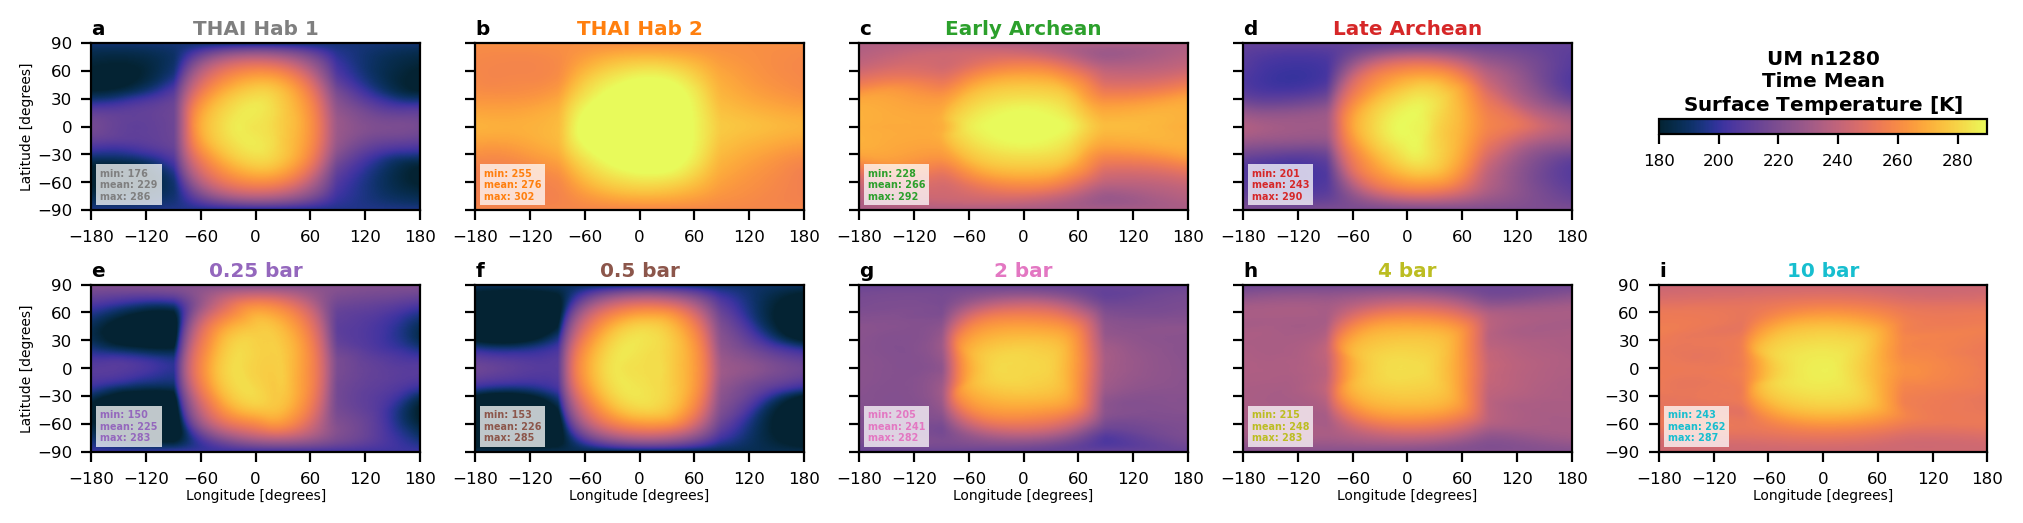

In [8]:
diag_key = "t_sfc"
ttl = f"UM {HIGHRES}\n\nTime Mean\n{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]"

fig = plt.figure(figsize=(10, 2.5), layout="constrained")
# fig.suptitle(ttl)

mosaic = [
    [*GROUPS["comp"].simulations] + ["cax"],
    [i for i in GROUPS["pres"].simulations if i != "hab1_1bar"],
]
axd = fig.subplot_mosaic(mosaic)  # , gridspec_kw={"hspace": 0.4}

iletters = subplot_label_generator()
for group in GROUPS.keys():
    for sim_label in GROUPS[group].simulations:
        if sim_label == "hab1_1bar":
            continue  # skip duplicate
        ax = axd[sim_label]
        ax.set_title(f"{next(iletters)}", loc="left")
        ax.set_title(
            SIMULATIONS[sim_label].title,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )

        cube = DIAGS[diag_key].recipe(dset[sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        if coord_mapping := coord_mappings.get(x.name()):
            x.convert_units(coord_mapping["units"])
            ax.set_xticks(coord_mapping["ticks"])
            ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
            )
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(
                f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
            )
        h = getattr(ax, DIAGS[diag_key].method)(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt
        )
        if (
            iris.util.guess_coord_axis(x) == "X"
            and iris.util.guess_coord_axis(y) == "Y"
        ):
            at = AnchoredText(
                cube_minmeanmax_str(
                    cube,
                    fmt=DIAGS[diag_key].fmt,
                    precision=1,
                    sep="\n",
                    eq_sign=": ",
                ),
                loc="lower left",
                frameon=True,
                prop={
                    "size": "xx-small",
                    "weight": "bold",
                    "color": SIMULATIONS[sim_label].kw_plt["color"],
                },
            )
            at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.75))
            at.patch.set_edgecolor("none")
            ax.add_artist(at)
legend_ax = axd["cax"]
legend_ax.set_aspect(5)
cbar = fig.colorbar(h, cax=legend_ax, orientation="horizontal")
legend_ax.set_title(ttl)

figsave(
    fig,
    paths.figures / "drafts" / f"thunderstruck__{HIGHRES}__all__{diag_key}__tm",
)

## Time series

In [9]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda AS: spatial_mean(AS.t_sfc),
        title="Surface Temperature",
        units="$K$",
    ),
    "toa_net": Diag(
        recipe=lambda AS: spatial_mean(AS.toa_net_energy),
        title="TOA Net Downward Energy",
        units="$W$ $m^{-2}$",
    ),
    "p_sfc": Diag(
        recipe=lambda AS: spatial_mean(AS.p_sfc),
        title="Surface Pressure",
        units="$bar$",
    ),
}

Saved to ../figures/drafts/thunderstruck__n1280__all__t_sfc__gm.png
Size: 97.2 KB
Saved to ../figures/drafts/thunderstruck__n1280__all__toa_net__gm.png
Size: 227.2 KB
Saved to ../figures/drafts/thunderstruck__n1280__all__p_sfc__gm.png
Size: 43.7 KB


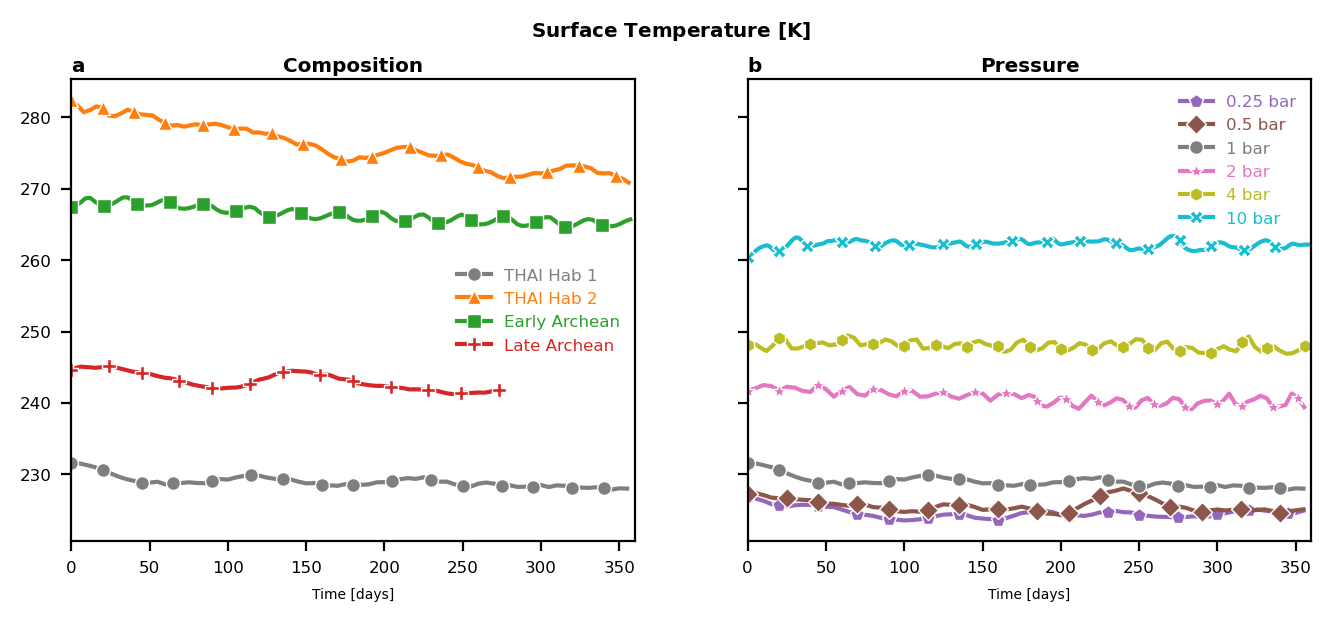

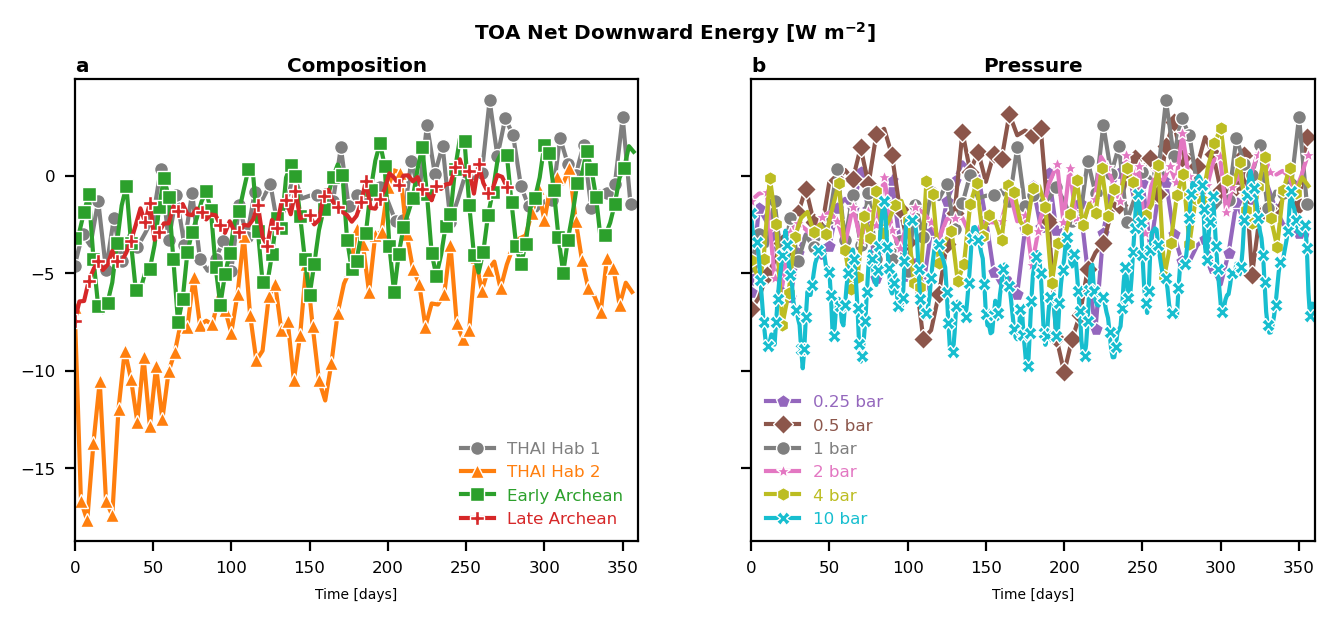

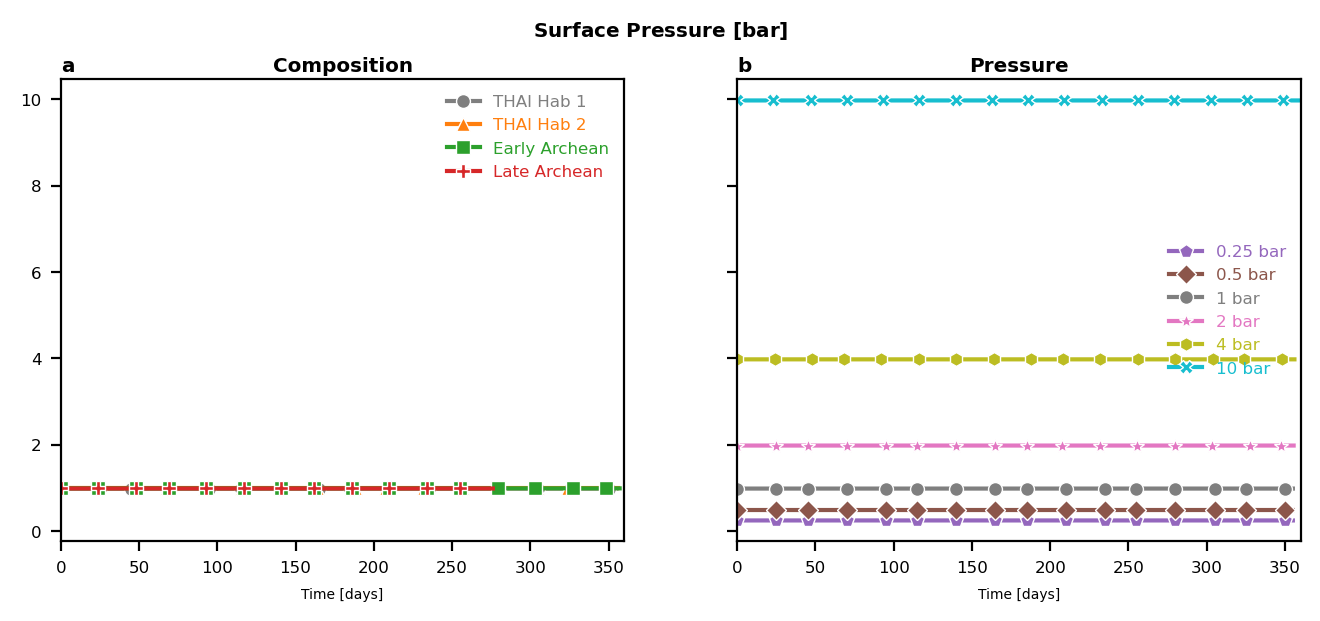

In [10]:
for diag_key in DIAGS.keys():

    fig = plt.figure(figsize=(8, 3))
    fig.suptitle(f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]")

    axd = fig.subplot_mosaic([[*GROUPS.keys()]], sharey=True)

    iletters = subplot_label_generator()
    for group in GROUPS.keys():
        for sim_label in GROUPS[group].simulations:
            cube = DIAGS[diag_key].recipe(dset[sim_label])
            cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
            timeseries_1d(
                cube,
                ax=axd[group],
                label=SIMULATIONS[sim_label].title,
                **KW_LINE_MARKERS,
                **SIMULATIONS[sim_label].kw_plt,
            )
        axd[group].set_xlabel("Time [days]")
        axd[group].set_title(
            GROUPS[group].title,
        )
        axd[group].set_title(
            f"{next(iletters)}",
            loc="left",
        )
        axd[group].legend(frameon=False)
        axd[group].set_xlim(0, 360)
    figsave(
        fig,
        paths.figures / "drafts" / f"thunderstruck__{HIGHRES}__all__{diag_key}__gm",
    )